# TODO

## Cloudformation yourself:

Building this by hand takes a lot of time. You have to:
- start EC2 instances
- you need an internal ip of the scheduler to start dask workers.
- create a complex security group.
- create an IAM role and link it to the EC2.
- Copy userdata.

It will be much more efficient if we can use cloudformation to create the cluster for us

## Create EC2Cluster

https://cloudprovider.dask.org/en/latest/aws.htm

## IAM 

Create a role and a user with S3 access. Give both `AmazonS3FullAccess` permission. The role will be linked when launching the EC2 instances below. Give it an easy to find name (e.g. `ec2-role-dask-cluster-s3`). You first need to create the user before you can give programmatic access. After creation go to the user and go the tab `security credentials`. On this tab the access keys can be generated.

## S3

Create a bucket `dask-input-data`. In which we can store the csv files from the tutorial on dask

## Start and prepare EC2 instances

In this notebook instruction are provided to start three EC2 instanes. On all three the same packages have to be installed. For this we use a the `userdata` section.

Go to the EC2 in the management console. 

Go to instances and click `Launch instances`

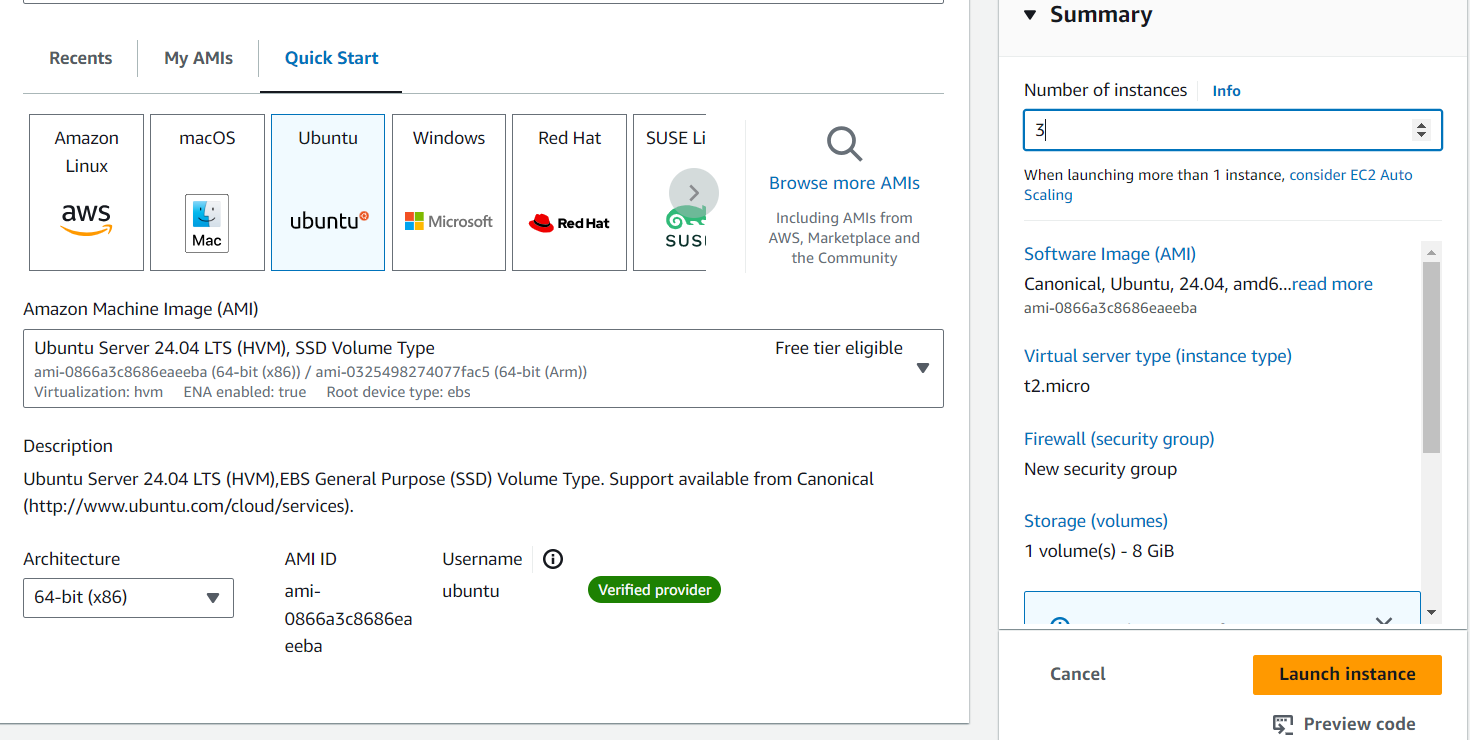

go down and make sure you select or create a `Key pair`

go down and under `Advanced details`. At the to you can link the role you created to the instances.

Then go to the user data (at the bottom)

copy the instruction below in the userdata part.

The above userdata will create a virtual enviroment. It will install the aws cli and specific versions of dask, distributed and bokeh. 

**remark** 
- you might need to update the userdata for specific versions in the future (and also pin down version of s3fs and dask-expr)
- note that the versions on the cluster need to match closely versions of the client. For that the `environment.yaml` was added. This only uses the `pip` install part to exactly install the versions on the cluster. Dask might not be able to perform the computations if the versions are different. This took me some time to figure out.
- The conda environment below works today (10/10/2024). **The awscli install is new and not tested yet** 

name: dask-cluster
channels:
  - defaults
  - conda-forge
  - pytorch
  - nvidia
dependencies:
  - python=3.10
  - pip
  - pip:
    - pandas==2.2.3
    - numpy==2.1.2
    - dask[complete]==2024.9.1
    - s3fs==2024.9.0
    - dask-expr==1.1.15
    - awscli
    - boto3
    - jupyter
  

create the enviroment `conda env create --file environment.yml`. **adjust the versions in the yaml file if necessary**

Launche the instances

Give the first instance the name `dask-scheduler` and the other two instances the name `dask-worker`

the user data instruction have been tested on an EC2 instance and they all worked. 

Due to the userdata starting the instances might take a bit longer.

## Opening port in the security group

Since the instances are all started at the same time they are all related to the same security group.

The security group can be found by selecting one of the instances and then go the the security tab.

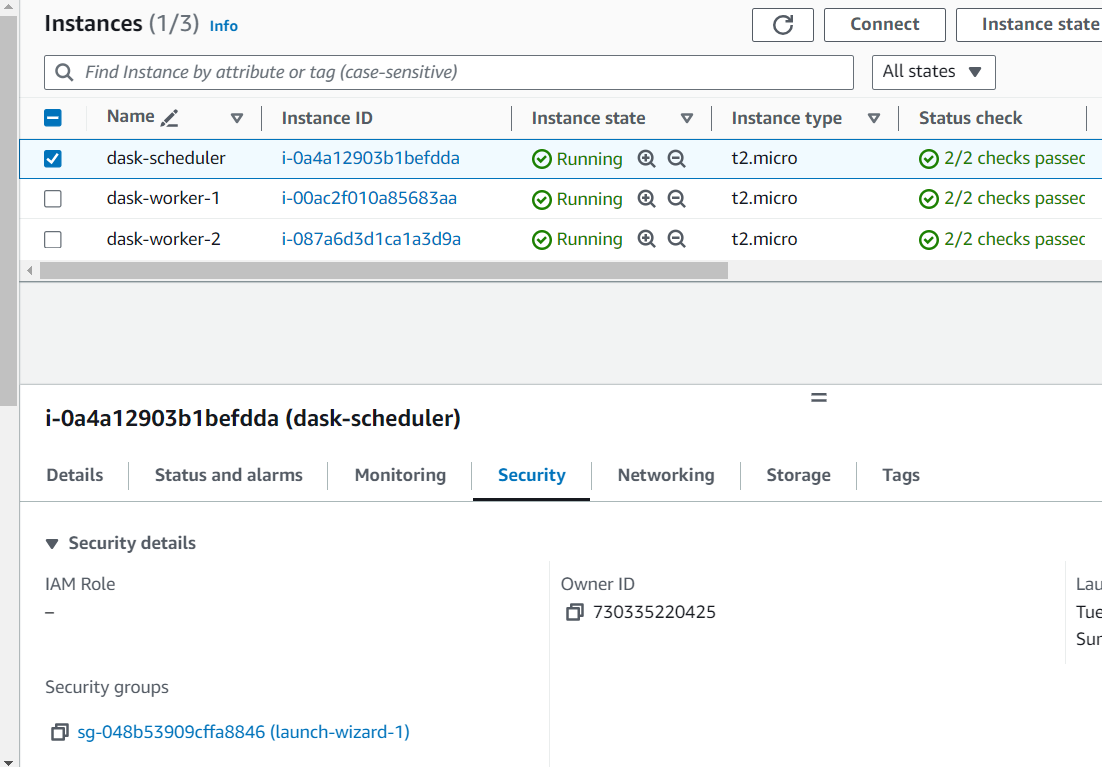

open the security group and go to `Edit Inbound Rules` under `Inbound Rules` then `Add Rule`. Add some rules and make sure it looks like in the image below

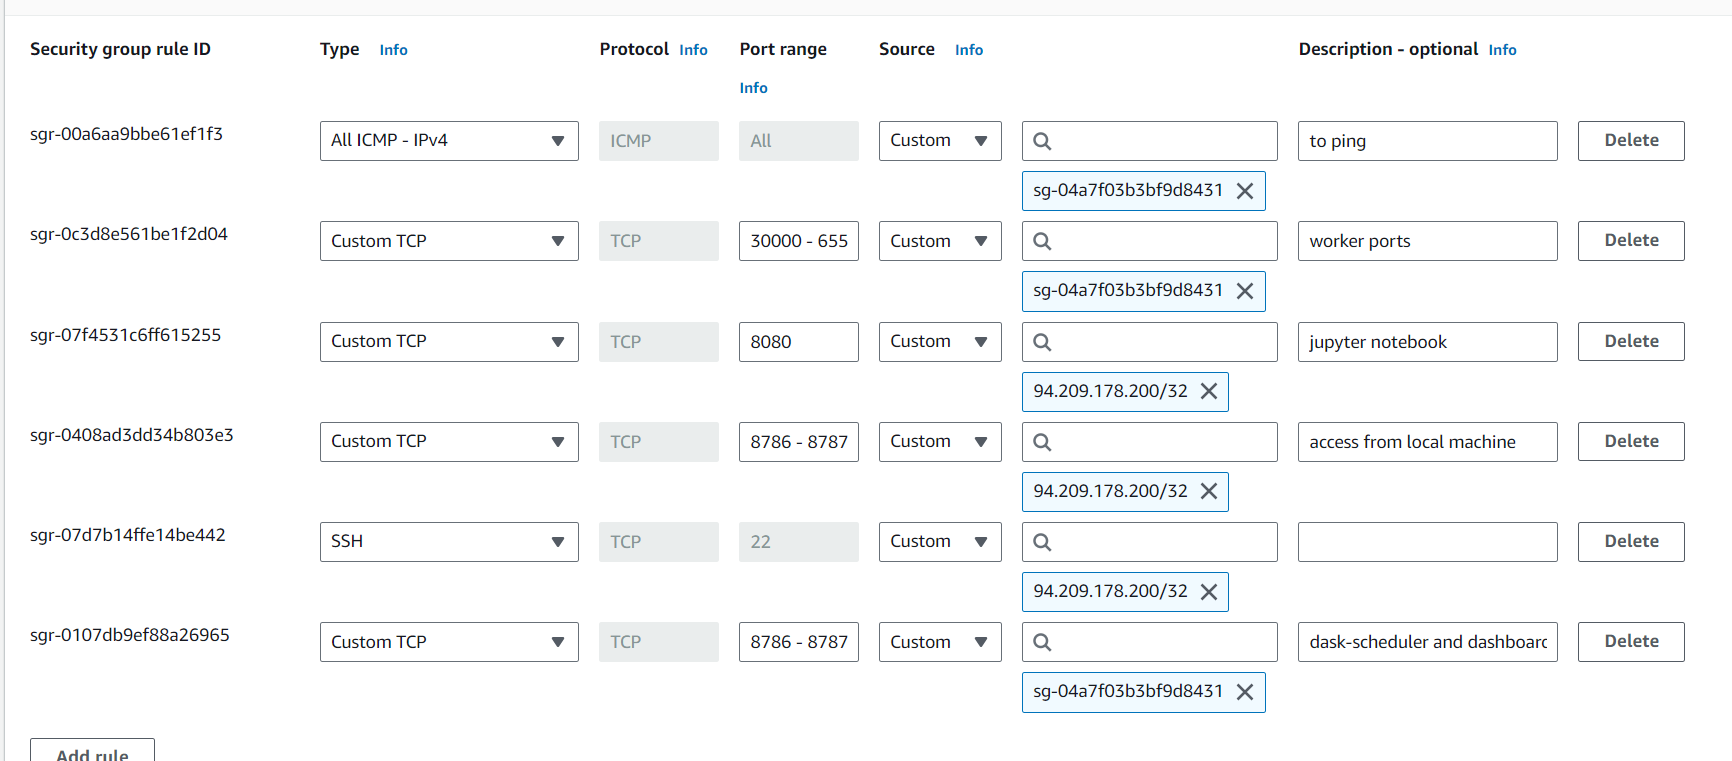

The unreadable part states port `30000-65535` (originally this was `49152-65535`). With the other range I was not able to get the cluster running. With the adjustment I was able to get get the cluster running. This had to do with for example nanny ports in the 30000-45000 range.

click save rules

log into the dask scheduler instance and try to ping the workers usine

`ping <private-ip-adress`

On my machine both pinged correctly.

## Setting up cluster with the CLI

log into each instance using for example Putty

in the terminal of the scheduler instance type:

`dask scheduler` 

this should among other show the something like below

```
2024-06-25 14:53:43,235 - distributed.scheduler - INFO -   Scheduler at:  tcp://172.31.21.203:8786
2024-06-25 14:53:43,235 - distributed.scheduler - INFO -   dashboard at:  http://172.31.21.203:8787/status
```

on each worker now execute

`dask worker tcp://172.31.21.203:8786`

this should return among others output that contains

```
2024-06-25 14:59:22,385 - distributed.nanny - INFO -         Start Nanny at: 'tcp://172.31.24.71:33373'
2024-06-25 14:59:23,015 - distributed.worker - INFO -       Start worker at:   tcp://172.31.24.71:46673
2024-06-25 14:59:23,016 - distributed.worker - INFO -          Listening to:   tcp://172.31.24.71:46673
2024-06-25 14:59:23,016 - distributed.worker - INFO -          dashboard at:         172.31.24.71:35887
2024-06-25 14:59:23,016 - distributed.worker - INFO - Waiting to connect to:   tcp://172.31.21.203:8786
2024-06-25 14:59:23,016 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,017 - distributed.worker - INFO -               Threads:                          1
2024-06-25 14:59:23,017 - distributed.worker - INFO -                Memory:                   0.94 GiB
2024-06-25 14:59:23,017 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-9tb94gip
2024-06-25 14:59:23,017 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,277 - distributed.worker - INFO - Starting Worker plugin shuffle
2024-06-25 14:59:23,278 - distributed.worker - INFO -         Registered to:   tcp://172.31.21.203:8786
2024-06-25 14:59:23,278 - distributed.worker - INFO - -------------------------------------------------
2024-06-25 14:59:23,279 - distributed.core - INFO - Starting established connection to tcp://172.31.21.203:8786
```



now the cluster is ready with one scheduler and 2 workers

### Remark

The userdata is really installed in the root. When loging using `Putty` we log in as `ubuntu` user in the directory `/home/ubuntu`. To get to the root directory we need to do cd .. twice. In this directory the `.venv` directory can be found.
To start the environment type 

`source .venv/bin/activate`

Then type the commands to start the scheduler and worker from the virtual environment (you see (venv))

Now we can see the daskboard using the **public ip** (not the private) 

`http://34.229.148.157:8787/status`

on this tab `workers`

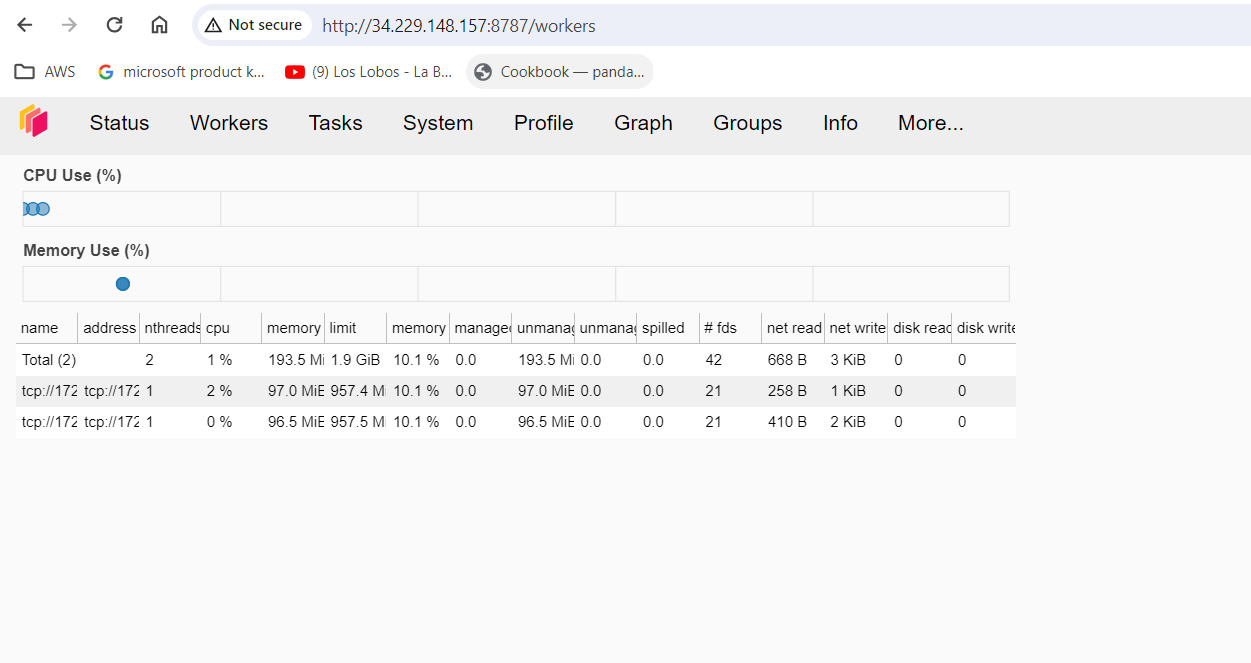

## Install the AWS CLI

_(This section is for completeness the aws cli is now installed in using the userdata, locally you can just use `pip install awscli`)_

check the link below to install the aws cli:

https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

you still need to assign roles to the EC2 instance if you want to access data in s3. After that you can test if it works by typing

`aws s3 ls` 

This will show any buckets in your account

## Checks

### package version check

In [98]:
# version checking
import pandas as pd
import numpy as np
import dask 
import dask_expr
import s3fs
import distributed

print(pd.__version__)
print(np.__version__)
print(dask.__version__)
print(s3fs.__version__)
print(distributed.__version__)
print(dask_expr.__version__)


2.2.3
2.1.2
2024.9.1
2024.9.0
2024.9.1
1.1.15


### Remote storage access check

Let's first see read data using pandas and dask without a cluster. This way we can check that our permissions for S3 work from the local machine.

In [99]:
%%time
import pandas as pd

# Example: Reading a CSV file from S3
df = pd.read_csv("s3://dask-input-data/1991.csv")
display(df.head(2))

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1991,1,8,2,1215.0,1215,1340.0,1336,US,121,...,NaN,4.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1991,1,9,3,1215.0,1215,1353.0,1336,US,121,...,NaN,17.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0


CPU times: total: 359 ms
Wall time: 5.16 s


In [15]:
%%time
import dask.dataframe as dd
from dask.distributed import Client

# create a local cluster
client = Client()

# Example: Reading a CSV file from S3
ddf = dd.read_csv('s3://dask-input-data/1990.csv', blocksize="10MB" )
print(ddf)

client.close()

# Connect locally to the scheduler

Now we try to connect from our local computer to the dask cluster. Please make sure that you use the **public IP** of the scheduler and not the private IP.

### Check connection to cluster

In [69]:
from dask.distributed import Client

# provide the public ip adress of the scheduler
ip = "44.202.6.3"
address = f"tcp://{ip}:8786"
dashboard = f"http://{ip}:8787/status"

print(f"Use the link below to connect to the cluster dashboard:\n{dashboard}")

print(address)
client = Client(address=address)

client

Use the link below to connect to the cluster dashboard:
http://44.202.6.3:8787/status
tcp://44.202.6.3:8786


<Client: 'tcp://172.31.87.82:8786' processes=2 threads=2, memory=3.84 GiB>

#### Simple example

In [70]:
import dask.array as da

a_da = da.ones(10, chunks=5)
a_da

dask.array<ones_like, shape=(10,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

In [71]:
a_da_sum = a_da.sum()
a_da_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [72]:
a_da_sum.compute()

np.float64(10.0)

#### Bigger example

In [73]:
xd = da.random.normal(10, 0.1, size=(20_000, 20_000), chunks=(3000, 3000))
xd

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(3000, 3000), chunktype=numpy.ndarray>

In [74]:
%%time
xd = da.random.normal(10, 0.1, size=(20_000, 20_000), chunks=(3000, 3000))
yd = xd.mean(axis=0)
yd.compute()

CPU times: total: 0 ns
Wall time: 6.03 s


array([10.00016617, 10.00181514,  9.99966933, ..., 10.00083309,
       10.00114234, 10.0002679 ])

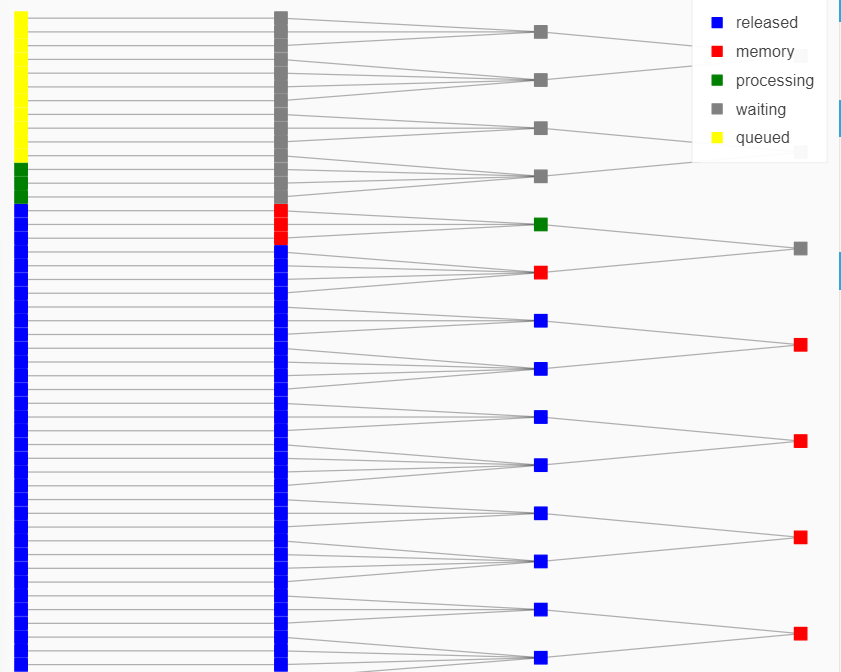

If it all works so far grab a coffee to celerate this **BIG SUCCES!**

## Cluster to use remote data on S3

The code below works for objects with public access. As an examle I made to csv files public and connect to them with dask. 

In [75]:
import dask.dataframe as dd
import os
import s3fs

you can point dask at a list of remote files

In [76]:
import dask.dataframe as dd

filenames = ["s3://dask-input-data/1990.csv", "s3://dask-input-data/1991.csv"]

# Example: Reading a CSV file from S3
ddf = dd.read_csv(filenames, 
                  parse_dates={"Date": [0, 1, 2]},
                  dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                  blocksize="10MB" )

ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=4,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,string,int64,string,float64,float64,float64,float64,float64,string,string,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


you can also point dask to all csv files in an s3 folder

In [77]:
import dask.dataframe as dd


# Read all CSV files from the root of the bucket
# ddf = dd.read_csv("s3://dask-input-data/*.csv", 
#                   parse_dates={"Date": [0, 1, 2]},
#                   dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
#                   blocksize="10MB" )

# Read all CSV files from the root of the bucket
ddf = dd.read_csv("s3://dask-input-data/*.csv", 
                  dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                  blocksize="25MB" )


ddf

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,float64,int64,float64,int64,string,int64,string,float64,float64,float64,float64,float64,string,string,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [78]:
%%time
len(ddf)

CPU times: total: 0 ns
Wall time: 9.03 s


2611892

In [79]:
ddf.head(2)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0


### Example calculations

In [80]:
%%time
result = ddf.DepDelay.max()
result.compute()

CPU times: total: 15.6 ms
Wall time: 4.3 s


np.float64(1435.0)

#### In total, how many non-canceled flights were taken?

In [81]:
len(ddf[~ddf.Cancelled])

2540961

#### In total, how many non-canceled flights were taken from each airport?

In [82]:
ddf[~ddf.Cancelled].groupby("Origin")["Origin"].count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

#### What was the average departure delay from each airport?

In [83]:
ddf.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

#### What day of the week has the worst average departure delay?

In [50]:
ddf.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'Diverted'],
      dtype='object')

In [85]:
ddf.groupby("DayOfWeek").DepDelay.mean().idxmax().compute()

np.int64(5)

In [ ]:
### Sharing

In [86]:
non_canceled = ddf[~ddf.Cancelled]
mean_delay = non_canceled.DepDelay.mean()
std_delay = non_canceled.DepDelay.std()

In [89]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: total: 62.5 ms
Wall time: 7.72 s


In [90]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)


CPU times: total: 15.6 ms
Wall time: 4.61 s


In [91]:
non_cancelled = ddf[~ddf.Cancelled]
ddf_jfk = non_cancelled[non_cancelled.Origin == "JFK"]

In [93]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.sum().compute()

CPU times: total: 78.1 ms
Wall time: 8.23 s


np.float64(4422520.0)

In [94]:
ddf_jfk = ddf_jfk.persist()

In [95]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.sum().compute()

CPU times: total: 15.6 ms
Wall time: 651 ms


np.float64(4422520.0)

In [100]:
client.close()

This takes abot 8 seconds with 2 workers. During this period you can go the dask dashboard to see and follow the execution of the task graph

# Run jupyter 

Now we want to run a jupyter notebook on the dask scheduler and connect to the cluster using a jupyter notebook on the scheduler (ideally you might want to setup the cluster and connect to it from your local machine - to be done). To create on an EC2 instance that runs jupyter and to which you can connect from your local machine you have to
- install jupyter on the server - use PuTTy to log into our dask-scheduler
- open up port 8080 (or another)
- execute the following command on the server - `jupyter notebook --no-browser --port=8080 --ip=0.0.0.0 --allow-root`

what is key is `--ip=0.0.0.0` without it will not work (several tries with different options)

The output will something like

` http://127.0.0.1:8080/tree?token=ea112db195c9c58c4a2043aac3b52b3897fab80dbf546e12`

replace the `127.0.0.1` with the external IP adress of the server and execute the whole expression in your local browser. Now you should be connected to the server notebook.

In [ ]:
from dask.distributed import Client

In [ ]:
client = Client()

In [ ]:
client

In [ ]:
client.close()